<a href="https://colab.research.google.com/github/ibad321/GAN-for-cifar100/blob/main/gan_for_cifar100_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD


In [ ]:
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD

In [ ]:
#Loading the CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar100.load_data()

save_path = '/kaggle/working/'


In [ ]:
print(x_train)

[[[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [195 205 193]
   [212 224 204]
   [182 194 167]]

  [[255 255 255]
   [254 254 254]
   [254 254 254]
   ...
   [170 176 150]
   [161 168 130]
   [146 154 113]]

  [[255 255 255]
   [254 254 254]
   [255 255 255]
   ...
   [189 199 169]
   [166 178 130]
   [121 133  87]]

  ...

  [[148 185  79]
   [142 182  57]
   [140 179  60]
   ...
   [ 30  17   1]
   [ 65  62  15]
   [ 76  77  20]]

  [[122 157  66]
   [120 155  58]
   [126 160  71]
   ...
   [ 22  16   3]
   [ 97 112  56]
   [141 161  87]]

  [[ 87 122  41]
   [ 88 122  39]
   [101 134  56]
   ...
   [ 34  36  10]
   [105 133  59]
   [138 173  79]]]


 [[[255 255 255]
   [253 253 253]
   [253 253 253]
   ...
   [253 253 253]
   [253 253 253]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255

In [ ]:
print(y_train)

[[19]
 [29]
 [ 0]
 ...
 [ 3]
 [ 7]
 [73]]


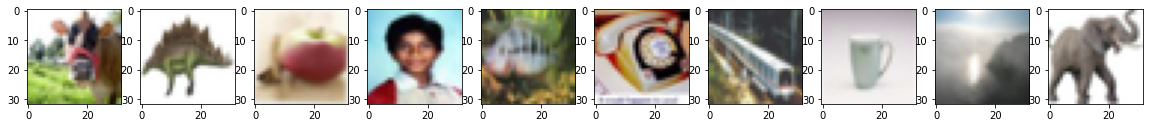

In [ ]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20,8))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

In [ ]:
#Defining the Input shape
image_shape = (32, 32, 3)

dimension = 100


In [ ]:
def build_generator():

    model = Sequential()

    # Building the input layer
    model.add(Dense(128 * 8 * 8, activation="relu",
                    input_dim=dimension))
    model.add(Reshape((8, 8, 128)))

    model.add(UpSampling2D())

    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.78))
    model.add(Activation("relu"))

    model.add(UpSampling2D())

    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.78))
    model.add(Activation("relu"))

    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=(dimension,))
    image = model(noise)

    return Model(noise, image)


In [ ]:
def build_discriminator():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2,
                     input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.82))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.82))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.25))

    # Building the output layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    image = Input(shape=image_shape)
    validity = model(image)

    return Model(image, validity)


In [ ]:
def display_images():
        r, c = 5,5
        noise = np.random.normal(0, 1, (r * c,dimension))
        generated_images = generator.predict(noise)

        #Scaling the generated images
        generated_images = 0.5 * generated_images + 0.5

        fig, axs = plt.subplots(r, c)
        count = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(generated_images[count, :,:,])
                axs[i,j].axis('off')
                plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
                count += 1
        plt.show()
        plt.close()


In [ ]:
# Building and compiling the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])

# Making the Discriminator untrainable
# so that the generator can learn from fixed gradients
discriminator.trainable = False

# Building the generator
generator = build_generator()

# Defining the input for the generator and generating the images
dummy = Input(shape=(dimension,))
image = generator(dummy)

# Checking the validity of the generated image
valid = discriminator(image)

# Defining the combined model of the Generator and the Discriminator
combined_network = Model(dummy, valid)
combined_network.compile(loss='binary_crossentropy',
                         optimizer=Adam(0.0002, 0.5))


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         1051267   
Total params: 1,051,267
Trainable params: 1,050,883
Non-trainable params: 384
_________________________________________________________________


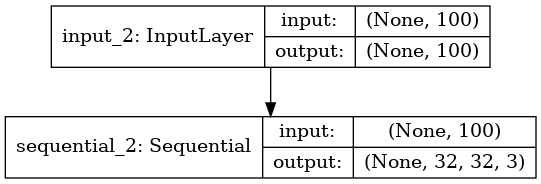

In [ ]:
from keras.utils import plot_model
generator.summary()
#plt.savefig('/kaggle/working/generator.png')
plot_model(generator, to_file='/kaggle/working/generator.png', show_shapes=True,show_layer_names=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 396609    
Total params: 792,322
Trainable params: 395,713
Non-trainable params: 396,609
_________________________________________________________________


/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


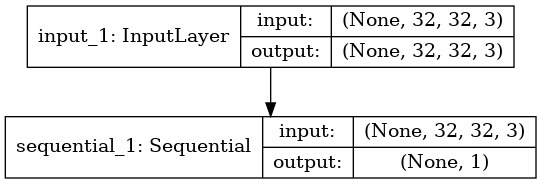

In [ ]:
from keras.utils import plot_model
discriminator.summary()
plot_model(discriminator, to_file='/kaggle/working/discriminator.png', show_shapes=True,show_layer_names=True)

In [ ]:
num_epochs=50000
batch_size=32
display_after=1000
losses=[]

#Normalizing the input
x_train = (x_train / 127.5) - 1

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


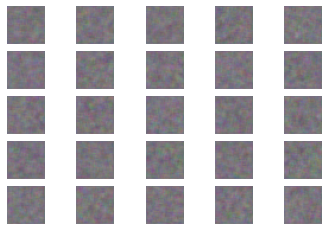

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


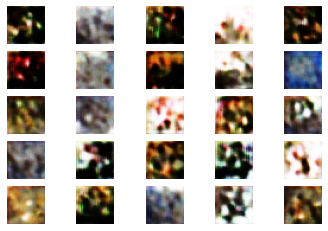

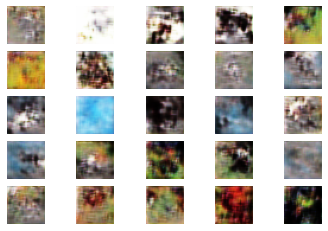

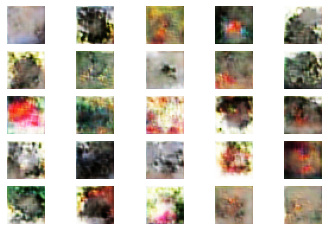

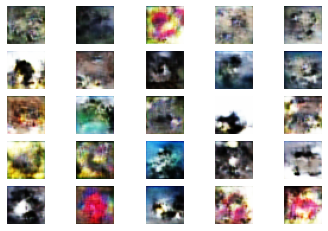

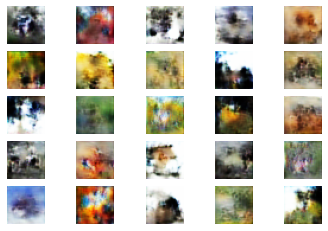

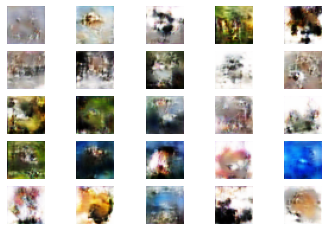

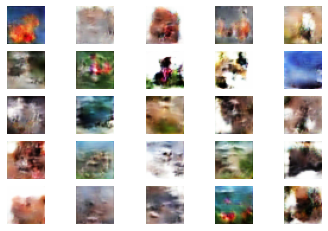

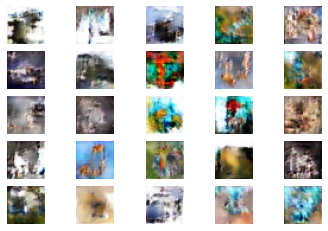

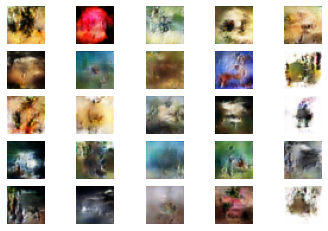

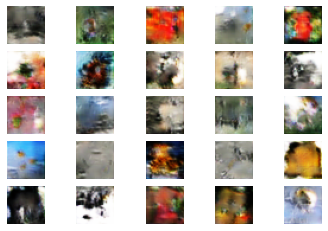

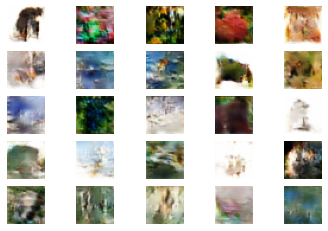

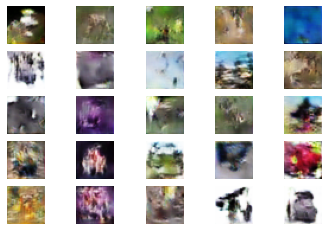

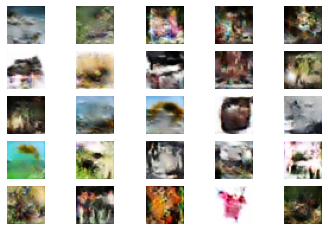

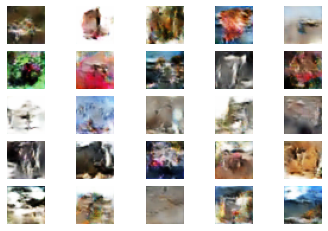

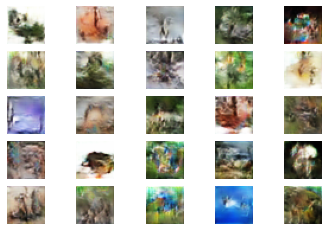

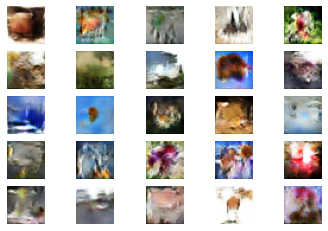

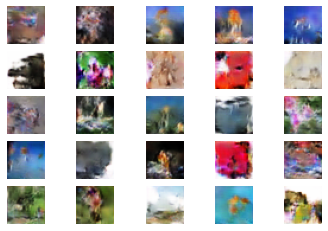

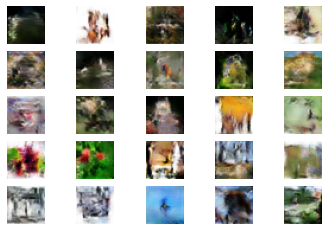

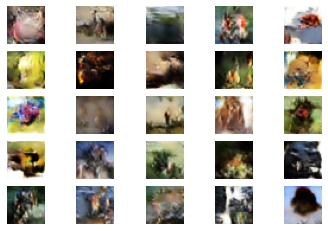

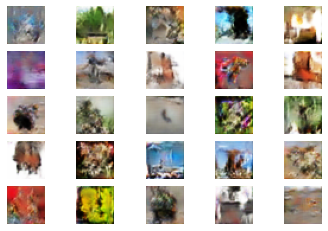

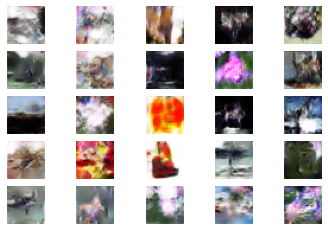

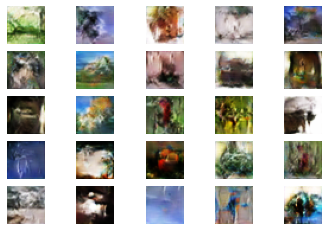

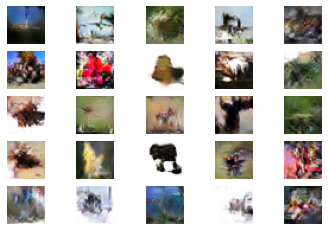

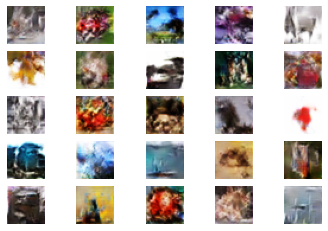

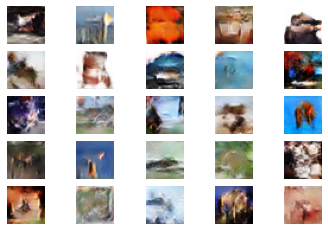

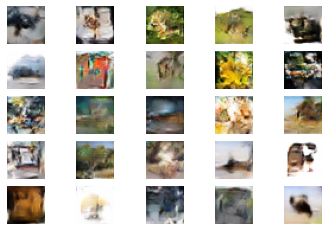

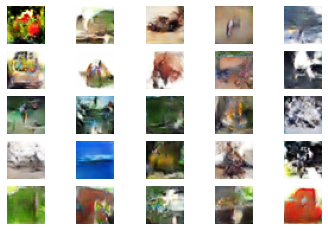

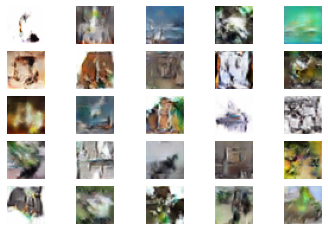

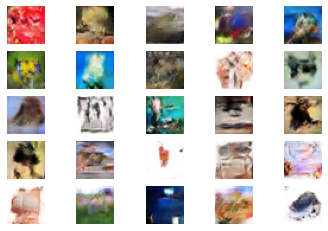

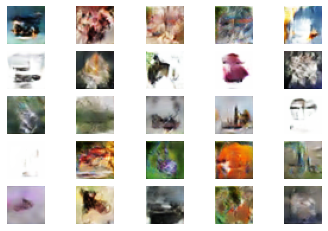

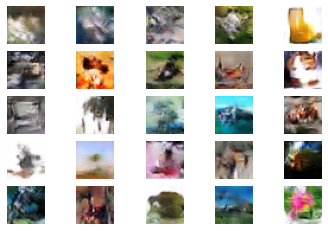

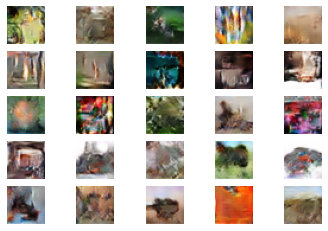

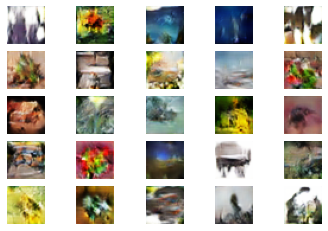

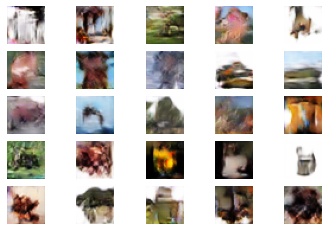

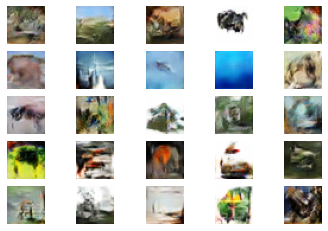

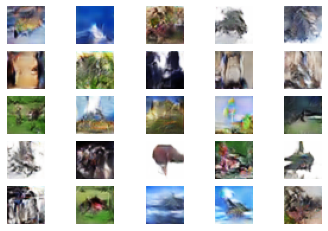

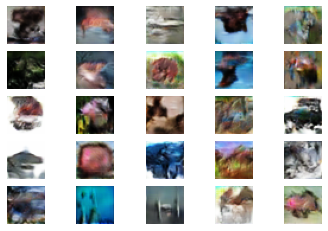

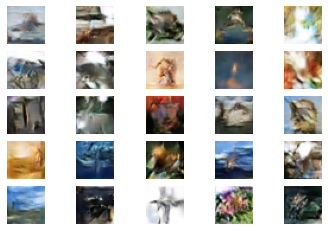

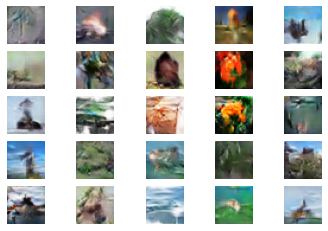

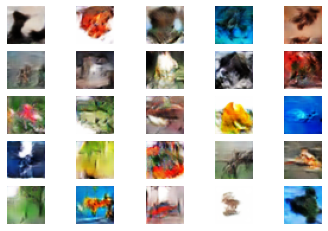

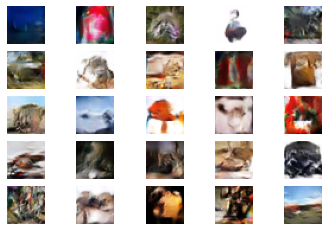

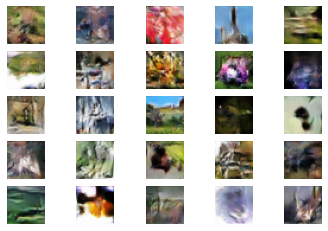

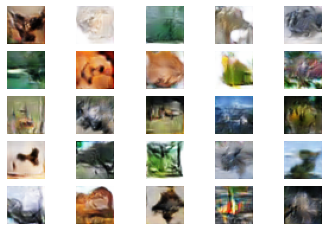

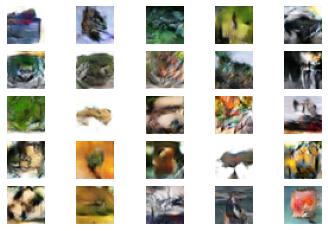

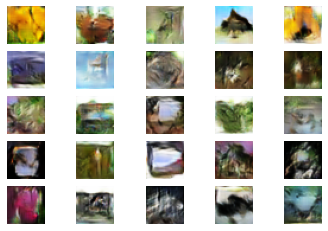

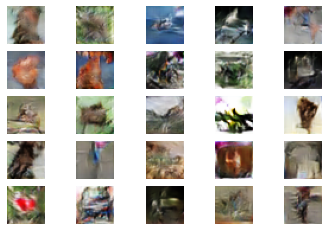

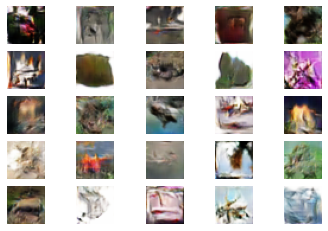

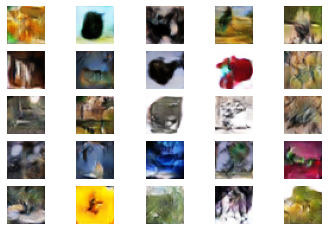

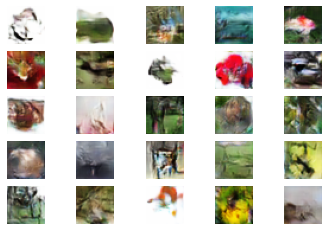

In [ ]:
# Defining the Adversarial ground truths
valid = np.ones((batch_size, 1))

# Adding some noise
valid += 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)

for epoch in range(num_epochs):

    # Training the Discriminator

    # Sampling a random half of images
    index = np.random.randint(0, x_train.shape[0], batch_size)
    images = x_train[index]

    # Sampling noise and generating a batch of new images
    noise = np.random.normal(0, 1, (batch_size, dimension))
    generated_images = generator.predict(noise)

    # Training the discriminator to detect more accurately
    # whether a generated image is real or fake
    discm_loss_real = discriminator.train_on_batch(images, valid)
    discm_loss_fake = discriminator.train_on_batch(generated_images, fake)
    discm_loss = 0.5 * np.add(discm_loss_real, discm_loss_fake)

    # Training the Generator

    # Training the generator to generate images
    # which pass the authenticity test
    genr_loss = combined_network.train_on_batch(noise, valid)

    # Tracking the progress
    if epoch % display_after == 0:
        display_images()
    '''plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
    plt.show()'''


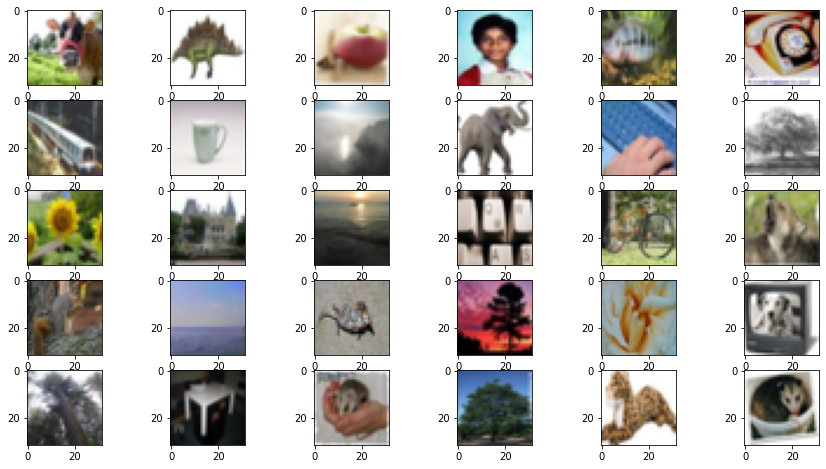

In [ ]:
#Plotting some of the original images
solid = x_train[:30]
solid = 0.5 * solid + 0.5
f, ax = plt.subplots(5,6, figsize=(15,8))
for i, image in enumerate(solid):
	ax[i//6, i%6].imshow(image)
	ax[i//6, i%6].axis('on')
plt.savefig("/kaggle/working/originalimages.png")
plt.show()


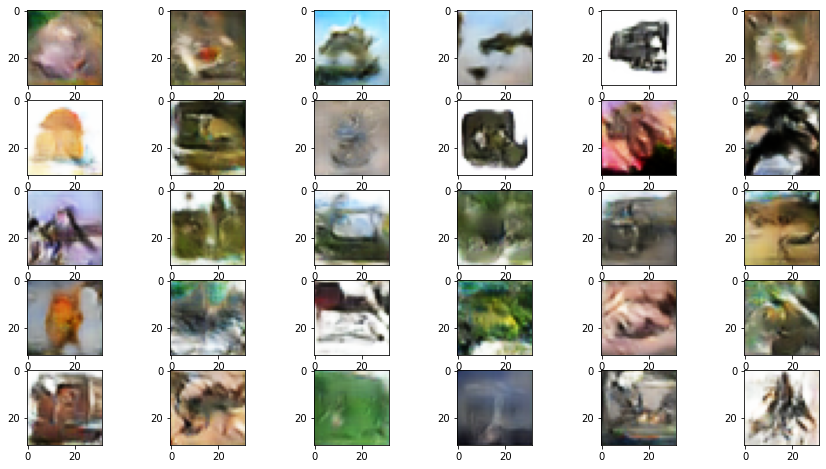

In [ ]:
#Plotting some of the last batch of generated images
noise = np.random.normal(size=(30, dimension))
generated_images = generator.predict(noise)
generated_images = 0.5 * generated_images + 0.5
f, ax = plt.subplots(5,6, figsize=(15,8))
for i, image in enumerate(generated_images):
	ax[i//6, i%6].imshow(image)
	ax[i//6, i%6].axis('on')
plt.savefig("/kaggle/working/reconstructedImages.png")
plt.show()


In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

In [ ]:
import re
import sys
from PIL import Image, ImageDraw

def func(x):
  for i in x:
    if(i.isdigit()):
      print(i)
      return int(i)
  return 10000000000

image_names = os.listdir(save_path)

frames = []
#for image in sorted(image_names, key=lambda name: int(''.join(i for i in name if i.isdigit()))):
for image in sorted(image_names, key=func):
    if(bool(re.search(r'\d', image))):
        print(image)
        frames.append(Image.open(save_path + '/' + image))

frames[0].save('/kaggle/working/reconstruction_process.gif', format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)

4
3
2
2
0
1
2
1
2
3
1
2
3
2
3
4
3
6
3
7
4
1
2
3
2
4
1
8
9
4
1
1
3
4
2
1
2
3
4
3
5
4
4
2
3
4
1
4
1
1
gan-images_epoch-0.png
gan-images_epoch-11000.png
gan-images_epoch-14000.png
gan-images_epoch-19000.png
gan-images_epoch-1000.png
gan-images_epoch-15000.png
gan-images_epoch-17000.png
gan-images_epoch-13000.png
gan-images_epoch-16000.png
gan-images_epoch-18000.png
gan-images_epoch-10000.png
gan-images_epoch-12000.png
gan-images_epoch-20000.png
gan-images_epoch-23000.png
gan-images_epoch-24000.png
gan-images_epoch-2000.png
gan-images_epoch-29000.png
gan-images_epoch-25000.png
gan-images_epoch-27000.png
gan-images_epoch-22000.png
gan-images_epoch-28000.png
gan-images_epoch-21000.png
gan-images_epoch-26000.png
gan-images_epoch-3000.png
gan-images_epoch-39000.png
gan-images_epoch-36000.png
gan-images_epoch-31000.png
gan-images_epoch-33000.png
gan-images_epoch-37000.png
gan-images_epoch-30000.png
gan-images_epoch-32000.png
gan-images_epoch-38000.png
gan-images_epoch-35000.png
gan-images_epoch

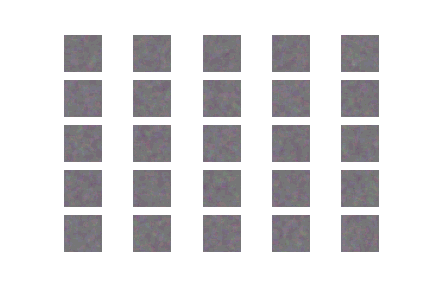

In [ ]:
from IPython.display import Image
Image("../working/reconstruction_process.gif")

save all the gifs, images and models to the drive

In [ ]:
discriminator.save('/kaggle/working/discriminator.h5')
generator.save('/kaggle/working/dcgenerator.h5')